# Import

In [2224]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder


# Chargement de la données

In [2225]:
chemin_fichier = "data/train.csv"
df = pd.read_csv(chemin_fichier)
# print(df.head())

In [2226]:
print(np.sum(df['Transported'] == True))
print(np.sum(df['Transported'] == False))

4378
4315


# Transformation de la données

In [2227]:
# Calcul du nombre de valeurs manquantes par colonne
missing_values_count = df.isnull().sum()

# Afficher les colonnes avec le nombre de valeurs manquantes
print("Nombre de valeurs manquantes par colonne:")
print(missing_values_count)

# Filtrer pour obtenir uniquement les colonnes avec des valeurs manquantes
columns_with_na = missing_values_count[missing_values_count > 0].index.tolist()

# Afficher uniquement les colonnes avec des valeurs manquantes
print("\nDataFrame avec uniquement les colonnes ayant des valeurs manquantes:")
print(df[columns_with_na])

Nombre de valeurs manquantes par colonne:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

DataFrame avec uniquement les colonnes ayant des valeurs manquantes:
     HomePlanet CryoSleep     Cabin    Destination   Age    VIP  RoomService  \
0        Europa     False     B/0/P    TRAPPIST-1e  39.0  False          0.0   
1         Earth     False     F/0/S    TRAPPIST-1e  24.0  False        109.0   
2        Europa     False     A/0/S    TRAPPIST-1e  58.0   True         43.0   
3        Europa     False     A/0/S    TRAPPIST-1e  33.0  False          0.0   
4         Earth     False     F/1/S    TRAPPIST-1e  16.0  False        303.0   
...         ...       ...       ...            ...   ...    ...          ...   
8688     Europa     False    A/98/P

In [2228]:
# Compter le nombre total de lignes
total_rows = len(df)
print("Nombre total de lignes:", total_rows)

# Compter les lignes contenant au moins une valeur manquante
rows_with_na = df.isnull().any(axis=1).sum()
print("Nombre de lignes avec au moins une valeur manquante:", rows_with_na)

# Compter le nombre de ligne avec n valeur(s) manquante(s)
n_nan_required = 1;
nan_counts = df.isnull().sum(axis=1)
count_n_nan = (nan_counts == n_nan_required).sum()
print(f"Nombre de lignes avec exactement {n_nan_required} valeurs manquantes: {count_n_nan}")

Nombre total de lignes: 8693
Nombre de lignes avec au moins une valeur manquante: 2087
Nombre de lignes avec exactement 1 valeurs manquantes: 1867


In [2229]:
# Initialisation de l'IterativeImputer
colonnes_numeriques = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

imputer = IterativeImputer(estimator=BayesianRidge(),
                           max_iter=10,
                           verbose=2,
                           random_state=42)
# Df histo 
df_orig = df.copy(deep=True)# Imputation
df[colonnes_numeriques] = imputer.fit_transform(df[colonnes_numeriques])

# Affichage
print(df[colonnes_numeriques].isnull().sum())

[IterativeImputer] Completing matrix with shape (8693, 6)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.02
[IterativeImputer] Change: 2579.328974680969, scaled tolerance: 29.813000000000002 
[IterativeImputer] Ending imputation round 2/10, elapsed time 0.04
[IterativeImputer] Change: 85.8027477445919, scaled tolerance: 29.813000000000002 
[IterativeImputer] Ending imputation round 3/10, elapsed time 0.10
[IterativeImputer] Change: 3.3544822285639384, scaled tolerance: 29.813000000000002 
[IterativeImputer] Early stopping criterion reached.
Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64


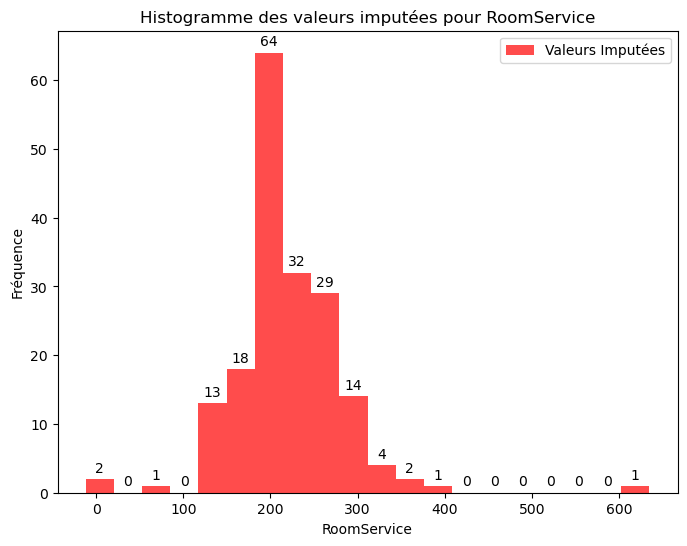

In [2230]:
# Affichage apres imputation par colonne
colonne = 'RoomService'

indices_modifies = np.where(np.isnan(df_orig[colonne]) & ~np.isnan(df[colonne]))

# S'assurer que nous utilisons les indices corrects pour accéder aux valeurs imputées dans df
valeurs_imputees = df.iloc[indices_modifies][colonne]

# Vérifier si 'valeurs_imputees' contient des données
if not valeurs_imputees.empty:
    plt.figure(figsize=(8, 6))
    n, bins, patches = plt.hist(valeurs_imputees, bins=20, color='red', alpha=0.7, label='Valeurs Imputées')
    plt.title('Histogramme des valeurs imputées pour ' + colonne)
    plt.xlabel(colonne)
    plt.ylabel('Fréquence')
    plt.legend()

    # Ajouter les annotations sur les barres
    for i in range(len(patches)):
        plt.annotate(str(int(n[i])), (patches[i].xy[0] + patches[i]._width / 2, n[i] + 1), ha='center')

    plt.show()
else:
    print("Aucune valeur imputée à afficher.")

In [2231]:
# Passenger_ID, séparation de la variable en deux variables Groupe_Numero
df[['Groupe', 'Numero']] = df['PassengerId'].str.split('_', expand=True)
df.drop('PassengerId', axis=1, inplace=True)
# print(df.head())

In [2232]:
# HomePlanet, 
# df['HomePlanet'] = df['HomePlanet'].fillna('Unknown')
# print(df.head())

In [2233]:
# Cabin,  séparation de la variable en trois champs : pont/num/côté
df['Cabin'] = df['Cabin'].fillna('0/0/0')
df[['Pont', 'Num', 'Cote']] = df['Cabin'].str.split('/', expand=True)
df.drop('Cabin', axis=1, inplace=True)
# print(df.head())

In [2234]:
# Destination, OneHotEncoding
# df['Destination'] = df['Destination'].fillna('Unknown')
# print(df.head())

In [2235]:
# nb_false = (df['CryoSleep'] == False).sum()
# nb_true = (df['CryoSleep'] == True).sum()
# print("Nombre de valeurs False dans 'CryoSleep':", nb_false)
# print("Nombre de valeurs True dans 'CrySleep':", nb_true)

# Remplacement des null par False
df['CryoSleep'] = df['CryoSleep'].fillna(False)

In [2236]:
# nb_false = (df['VIP'] == False).sum()
# nb_true = (df['VIP'] == True).sum()
# print("Nombre de valeurs False dans 'VIP':", nb_false)
# print("Nombre de valeurs True dans 'VIP':", nb_true)

# Remplacement des null par False
df['VIP'] = df['VIP'].fillna(False)

In [2237]:
#Suppression de la colonne Name
df.drop('Name', axis=1, inplace=True)

## Conversion des types

In [2238]:
df['CryoSleep'].astype(bool)
df['Age'].astype(int)
df['VIP'].astype(bool)
df['RoomService'].astype(int)
df['FoodCourt'].astype(int)
df['ShoppingMall'].astype(int)
df['Spa'].astype(int)
df['VRDeck'].astype(int)
df['Transported'].astype(bool)
df['Groupe'] = pd.to_numeric(df['Groupe'], errors='coerce')
df['Numero'] = pd.to_numeric(df['Numero'], errors='coerce')
df['Num'] = pd.to_numeric(df['Num'], errors='coerce')

# LabelEncoding : Vient attribuer un nombre unique a chaque catgeorie
label_encoder = LabelEncoder()
df['Pont'] = label_encoder.fit_transform(df['Pont'])
df['Cote'] = label_encoder.fit_transform(df['Cote'])

# OneHotEncoding 
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')  # drop='first' pour éviter le piège de la multicollinéarité
# Encodage pour 'HomePlanet'
homeplanet_encoded = ohe.fit_transform(df[['HomePlanet']])
homeplanet_encoded_df = pd.DataFrame(homeplanet_encoded, columns=ohe.get_feature_names_out(['HomePlanet']))
# Encodage pour 'Destination'
destination_encoded = ohe.fit_transform(df[['Destination']])
destination_encoded_df = pd.DataFrame(destination_encoded, columns=ohe.get_feature_names_out(['Destination']))
# Concatener les DataFrames
df = pd.concat([df.drop(['HomePlanet', 'Destination'], axis=1), homeplanet_encoded_df, destination_encoded_df], axis=1)

#Affichage 
print(df.head())

   CryoSleep   Age    VIP  RoomService  FoodCourt  ShoppingMall     Spa  \
0      False  39.0  False          0.0        0.0           0.0     0.0   
1      False  24.0  False        109.0        9.0          25.0   549.0   
2      False  58.0   True         43.0     3576.0           0.0  6715.0   
3      False  33.0  False          0.0     1283.0         371.0  3329.0   
4      False  16.0  False        303.0       70.0         151.0   565.0   

   VRDeck  Transported  Groupe  Numero  Pont  Num  Cote  HomePlanet_Europa  \
0     0.0        False       1       1     2    0     1                1.0   
1    44.0         True       2       1     6    0     2                0.0   
2    49.0        False       3       1     1    0     2                1.0   
3   193.0        False       3       2     1    0     2                1.0   
4     2.0         True       4       1     6    1     2                0.0   

   HomePlanet_Mars  HomePlanet_nan  Destination_PSO J318.5-22  \
0              

In [2239]:
# Enregistrement du DataSet dans un csv
try:
    df.to_csv('data/dataset.csv', index=False)
    print("Fichier enregistré avec succès.")
except Exception as e:
    print(f"Erreur lors de l'enregistrement du fichier : {e}")

Fichier enregistré avec succès.


In [2240]:
# Supprimer les lignes contenant des NaN
# df = df.dropna()

# Initialisation des modèles

In [2241]:
# Séparation des features et de la cible
X = df.drop('Transported', axis=1)
y = df['Transported']

# Définir le pipeline
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),   # Étape de normalisation
    ('classifier', LogisticRegression())  # Étape de classification
])

# Définir le pipeline
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),   # Étape de normalisation
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))  # Étape de classification
])

# Définir le pipeline
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),   # Étape de normalisation
    ('classifier', XGBClassifier(n_estimators=100, random_state=42))  # Étape de classification
])

# Importance des caractéristiques

In [2242]:
# # Logistic Regression
# # Afficher l'importance
# importance = lr.coef_[0]
# for i, v in enumerate(importance):
#     print(f'Feature: {X.columns[i]}, Score: {v}')

In [2243]:
# # Random Forest
# # Obtenir les importances des caractéristiques
# importances = rf.feature_importances_
# 
# # Afficher les importances
# for i, importance in enumerate(importances):
#     print(f"Feature: {X.columns[i]}, Importance: {importance}")

# Prédiction et évaluation

In [2244]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

# Configuration de StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross Validation
# Métriques multiples
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_macro',
    'recall': 'recall_macro',
    'f1_score': 'f1_macro'
}

# Logistic Regression
# Cross Validation pour chaque modèle
lr_results = cross_validate(lr_pipeline, X, y, cv=skf, scoring=scoring)

print("Logistic Regression")
print("Accuracy:", np.mean(lr_results['test_accuracy']))
print("Precision:", np.mean(lr_results['test_precision']))
print("Recall:", np.mean(lr_results['test_recall']))
print("F1 Score:", np.mean(lr_results['test_f1_score']))

# Random Forest
rf_results = cross_validate(rf_pipeline, X, y, cv=skf, scoring=scoring)

print("\nRandom Forest Classifier")
print("Accuracy:", np.mean(rf_results['test_accuracy']))
print("Precision:", np.mean(rf_results['test_precision']))
print("Recall:", np.mean(rf_results['test_recall']))
print("F1 Score:", np.mean(rf_results['test_f1_score']))

# Random Forest
xgb_results = cross_validate(xgb_pipeline, X, y, cv=skf, scoring=scoring)

print("\nXGBoost Classifier")
print("Accuracy:", np.mean(xgb_results['test_accuracy']))
print("Precision:", np.mean(xgb_results['test_precision']))
print("Recall:", np.mean(xgb_results['test_recall']))
print("F1 Score:", np.mean(xgb_results['test_f1_score']))

Logistic Regression
Accuracy: 0.7930524334779655
Precision: 0.7935700838212079
Recall: 0.7929120955056732
F1 Score: 0.7929044136901879

Random Forest Classifier
Accuracy: 0.8020238341811193
Precision: 0.8031595079990079
Recall: 0.8022393927643598
F1 Score: 0.8019059174128982

XGBoost Classifier
Accuracy: 0.7977685150321833
Precision: 0.7979451890509102
Recall: 0.7978319714825405
F1 Score: 0.7977527675828434


# Visualisation des résultats

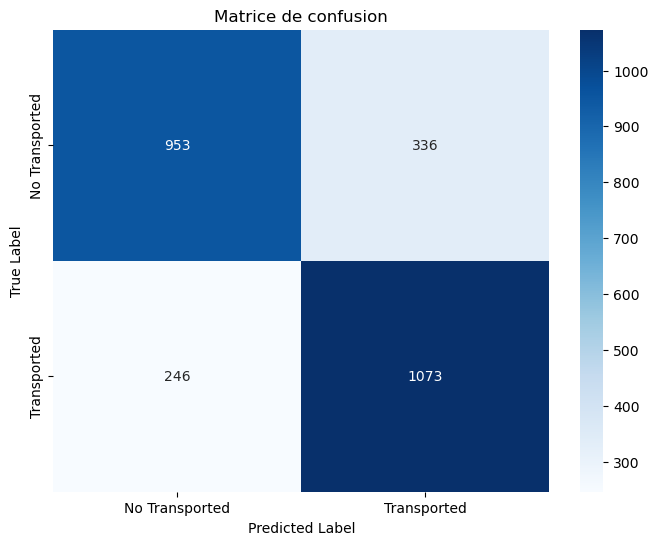

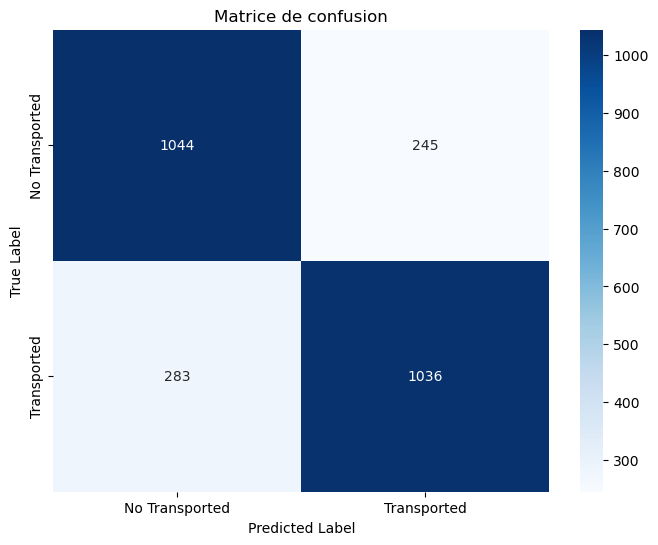

In [2245]:
plt.figure(figsize=(8, 6))
sns.heatmap(lr_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Transported', 'Transported'], yticklabels=['No Transported', 'Transported'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matrice de confusion')

plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Transported', 'Transported'], yticklabels=['No Transported', 'Transported'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matrice de confusion')
plt.show()